<a href="https://colab.research.google.com/github/munich-ml/MLPy2020/blob/master/17_Logfiles_w_Pandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logfile challenge

## setup

This following code block prepares the coding challenge:
1. clone GitHub project `MLPy2020`
1. import and execute `create_csv` helper function
1. open file `logfile.csv` and store content into variable `s`


In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get munich-ml repo from GitHub
if "MLPy2020" in os.listdir():
    !git -C MLPy2020 pull
else:
    !git clone https://github.com/munich-ml/MLPy2020/

from MLPy2020.MLPy_helper_funcs import parse_logfile_string

with open(os.path.join("MLPy2020", "datasets", "logfile.csv"), "r") as file:
    s = file.read()

    

Cloning into 'MLPy2020'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 145 (delta 68), reused 68 (delta 20), pack-reused 0
Receiving objects: 100% (145/145), 721.92 KiB | 2.07 MiB/s, done.
Resolving deltas: 100% (68/68), done.


# Reuse functions from **NumPy** session



In [0]:
def apply_calibration(log):
    for param, cal_factor in log["params"].items():
        if "calibration factor" in param:
            sig = param.split(" ")[-1]
            col_index = log["names"].index(sig)

            # append the new column with calibrated data to the right
            new_col = log["data"][:, col_index] * float(cal_factor)
            log["data"] = np.column_stack([log["data"], new_col])

            # also add the new name to the names list
            log["names"].append(sig + "_cal") 

In [0]:
def plot(log, sig_names):
    x = log["data"][:, log["names"].index("x")]
    for sig_name in sig_names:
        if sig_name in log["names"]:
            y = log["data"][:, log["names"].index(sig_name)]
            plt.plot(x, y, "o", label=sig_name)
        else:
            print("Warning, '{}' is not in 'log['names']'!".format(sig_name))
    plt.grid(), plt.legend(), plt.tight_layout()

In [0]:
def parse_logfile_string_to_numpy(s):
    """
    Wraps 'parse_logfile_string' function and converts the "data" list of lists to an NumPy array
    """
    log_dict = parse_logfile_string(s)
    log_dict["data"] = np.array(log_dict["data"])
    return log_dict

In [0]:
log = parse_logfile_string_to_numpy(s)

print("data head before calibration:")
print(log["names"])
print(log["data"][:3, :])

apply_calibration(log)

print("data head after calibration:")
print(log["names"])
print(log["data"][:3, :])

data head before calibration:
['x', 'sig0', 'sig1', 'sig2']
[[ 5.17   6.4   16.05  10.61 ]
 [ 9.47  34.21   5.95   0.293]
 [ 7.65  21.11   0.366  4.8  ]]
data head after calibration:
['x', 'sig0', 'sig1', 'sig2', 'sig0_cal', 'sig2_cal']
[[ 5.17     6.4     16.05    10.61     3.52    19.9468 ]
 [ 9.47    34.21     5.95     0.293   18.8155   0.55084]
 [ 7.65    21.11     0.366    4.8     11.6105   9.024  ]]


Warning, 'sig1_cal' is not in 'log['names']'!
Warning, 'sig42' is not in 'log['names']'!


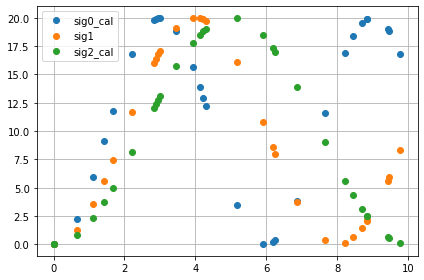

In [0]:
plot(log, sig_names=["sig0_cal", "sig1_cal", "sig1", "sig42", "sig2_cal"])

... the NumPy version still works.

Next, lets introduce **Pandas**...

# Exercise
1. Create a `parse_logfile_string_to_pandas` that returns `data` and `names` are in a `Pandas.DataFrame`
1. Rework `apply_calibration` function to accept the new `DataFrame`
1. Rework `plot` function to accept the new `DataFrame`

## Testing `parse_logfile_string_to_pandas` 

In [0]:
def parse_logfile_string_to_pandas(s):
    """
    Wraps 'parse_logfile_string' function and converts the "data" list of lists to a Pandas DataFrame
    """
    log = parse_logfile_string(s)
    df = pd.DataFrame(np.array(log["data"]), 
                      columns=log["names"])
    return {"params": log["params"], "data": df}

In [0]:
log = parse_logfile_string_to_pandas(s)
log["data"].head()

,x,sig0,sig1,sig2
0,5.17,6.40,16.050,10.610
1,9.47,34.21,5.950,0.293
2,7.65,21.11,0.366,4.800
3,2.82,36.06,16.030,6.390
4,2.21,30.50,11.650,4.360


## Testing `apply_calibration` 

In [0]:
def apply_calibration(log):
#  predecessor NumPy version
#    for param, cal_factor in log["params"].items():
#        if "calibration factor" in param:
#            sig = param.split(" ")[-1]
#            col_index = log["names"].index(sig)
#
#            # append the new column with calibrated data to the right
#            new_col = log["data"][:, col_index] * float(cal_factor)
#            log["data"] = np.column_stack([log["data"], new_col])
#
#            # also add the new name to the names list
#            log["names"].append(sig + "_cal") 
    
    for param, cal_factor in log["params"].items():
        if "calibration factor" in param:
            sig = param.split(" ")[-1]
            log["data"][sig + "_cal"] = log["data"][sig] * float(cal_factor)

In [0]:
apply_calibration(log)
log["data"].head()

,x,sig0,sig1,sig2,sig0_cal,sig2_cal
0,5.17,6.40,16.050,10.610,3.5200,19.94680
1,9.47,34.21,5.950,0.293,18.8155,0.55084
2,7.65,21.11,0.366,4.800,11.6105,9.02400
3,2.82,36.06,16.030,6.390,19.8330,12.01320
4,2.21,30.50,11.650,4.360,16.7750,8.19680


## Testing `plot` 

In [0]:
def plot(log, sig_names):
#  predecessor NumPy version
#    x = log["data"][:, log["names"].index("x")]
#    for sig_name in sig_names:
#        if sig_name in log["names"]:
#            y = log["data"][:, log["names"].index(sig_name)]
#            plt.plot(x, y, "o", label=sig_name)
#        else:
#            print("Warning, '{}' is not in 'log['names']'!".format(sig_name))
#    plt.grid(), plt.legend(), plt.tight_layout()

    data = log["data"]
    for sig_name in sig_names:        
        if sig_name in data.columns:
            plt.plot(data["x"], data[sig_name], "o", label=sig_name)
        else:
            print("Warning, '{}' is not in 'log['names']'!".format(sig_name))
    plt.grid(), plt.legend(), plt.tight_layout()
 

Warning, 'sig1_cal' is not in 'log['names']'!
Warning, 'sig42' is not in 'log['names']'!


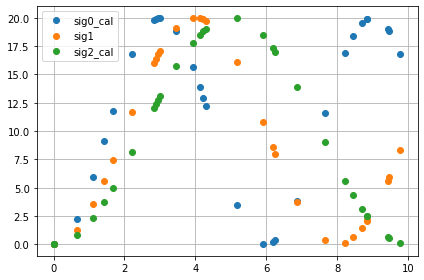

In [0]:
plot(log, sig_names=["sig0_cal", "sig1_cal", "sig1", "sig42", "sig2_cal"])